In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
series = read_csv('../data/single bill for cluster 0.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [3]:
series2 = read_csv('../data/single bill for cluster 1.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [4]:
series3 = read_csv('../data/single bill for cluster 2.csv .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [8]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.08130434],
       [-0.44992802],
       [ 0.46123597],
       [-0.13707334],
       [ 0.3995811 ],
       [-0.27582082],
       [ 0.393348  ],
       [ 0.20219335],
       [-0.4701584 ],
       [-0.43165094],
       [ 0.28661945],
       [-0.26302138],
       [ 0.5149728 ],
       [-0.13308424],
       [ 0.3770735 ],
       [-0.29646778],
       [-0.23085995],
       [-0.05179051],
       [ 0.5685098 ],
       [-0.02190401],
       [-0.41174695],
       [ 0.46891525],
       [-0.11390868],
       [ 0.5156883 ],
       [ 0.01131684],
       [-0.17312984],
       [ 0.51583385],
       [-0.12808874],
       [ 0.05555159],
       [-0.35044122],
       [ 0.28545335],
       [-0.00280307],
       [ 0.4296477 ],
       [-0.12042998],
       [-0.5852717 ],
       [ 0.46964625],
       [-0.02729242],
       [-0.3740877 ],
       [ 0.3464178 ],
       [-0.28911743],
       [ 0.5143181 ],
       [-0.12962592],
       [ 0.44722924],
       [-0.1899611 ]], dtype=float32)

In [9]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=1532.396737, Expected=2107.000000
1/1 [==============================] - 0s 19ms/step
Month=2, Predicted=1366.174576, Expected=1324.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2024.472941, Expected=1050.000000


Test RMSE: 685.067
Test MAE: 548.667


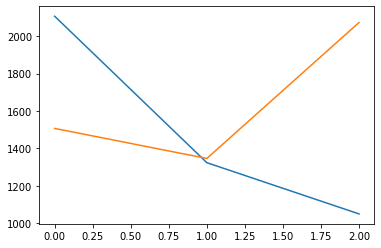

In [10]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [10]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.23111299],
       [-0.50990933],
       [ 0.11843817],
       [-0.54428184],
       [-0.25160977],
       [ 0.26584852],
       [-0.5487217 ],
       [ 0.08911259],
       [ 0.12541881],
       [-0.14456058],
       [-0.6865395 ],
       [-0.25717378],
       [ 0.09908281],
       [ 0.02691455],
       [-0.17513382],
       [ 0.3923259 ],
       [-0.32668346],
       [-0.32293773],
       [ 0.28288162],
       [-0.02116838],
       [-0.14096549],
       [ 0.24000096],
       [-0.12374312],
       [ 0.13329008],
       [-0.4169324 ],
       [ 0.19973066],
       [-0.27281964],
       [-0.44803286],
       [-0.51993597],
       [ 0.07218191],
       [ 0.4398272 ],
       [-0.38731587],
       [-0.50644237],
       [ 0.06782271],
       [ 0.5246914 ],
       [-0.44786233],
       [ 0.15258004],
       [-0.03672416],
       [ 0.45252138],
       [ 0.33471212],
       [-0.09981648],
       [ 0.382452  ],
       [ 0.60842955],
       [ 0.557218  ]], dtype=float32)

In [11]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=319.122868, Expected=53.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=154.414455, Expected=185.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=128.932606, Expected=52.000000


Test RMSE: 160.909
Test MAE: 124.547


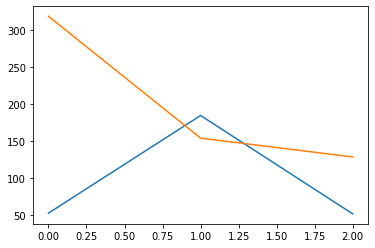

In [12]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values2[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [13]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.08471499],
       [-0.31803176],
       [-0.18947673],
       [-0.7788497 ],
       [-0.18428841],
       [-0.03483667],
       [-0.32200134],
       [-0.05460442],
       [ 0.11234634],
       [-0.43684202],
       [ 0.34403396],
       [ 0.17757262],
       [-0.41330433],
       [-0.2204341 ],
       [-0.19012964],
       [-0.4876668 ],
       [ 0.32562608],
       [-0.67975855],
       [ 0.25446513],
       [-0.15571728],
       [ 0.3756331 ],
       [ 0.05748644],
       [-0.64533854],
       [-0.39562646],
       [ 0.18496272],
       [ 0.5046627 ],
       [ 0.4243223 ],
       [-0.41416317],
       [ 0.10892377],
       [ 0.02198943],
       [-0.08320884],
       [ 0.16326678],
       [ 0.3112608 ],
       [ 0.04353358],
       [-0.30160466],
       [ 0.30215308],
       [-0.0466106 ],
       [ 0.04459435],
       [-0.42276943],
       [ 0.18241689],
       [-0.1485981 ],
       [ 0.06827579],
       [ 0.39012837],
       [ 0.05017036]], dtype=float32)

In [14]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 19ms/step
Month=1, Predicted=2982.147553, Expected=2889.000000
1/1 [==============================] - 0s 23ms/step
Month=2, Predicted=3006.561449, Expected=2209.000000
1/1 [==============================] - 0s 16ms/step
Month=3, Predicted=2832.316767, Expected=2589.000000


Test RMSE: 484.418


Test MAE: 378.009


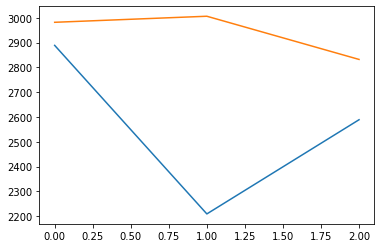

In [15]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values3[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()